# Clean up for your vacation images

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [2]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

In [3]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1

df[[c for c in df.columns if not c.endswith('_images')]].head()

,file,creation_date,timediff_value,target
23,ar_1.JPG,1487935036,0.0,1
22,ar_0.JPG,1487935036,16.0,1
25,as_1.JPG,1487935052,0.0,2
24,as_0.JPG,1487935052,10.0,2
26,at_0.JPG,1487935062,2.0,3


# Bootstrap to augment sample size

In [4]:
res = sc.bootstrap_data(df, n_runs=10)
res[0].columns

Index(['target', 'creation_date', 'hash_value', 'correl_corr',
       'bhattacharyya_corr'],
      dtype='object')

# Method 1: Estimate mean values

## For Hashing

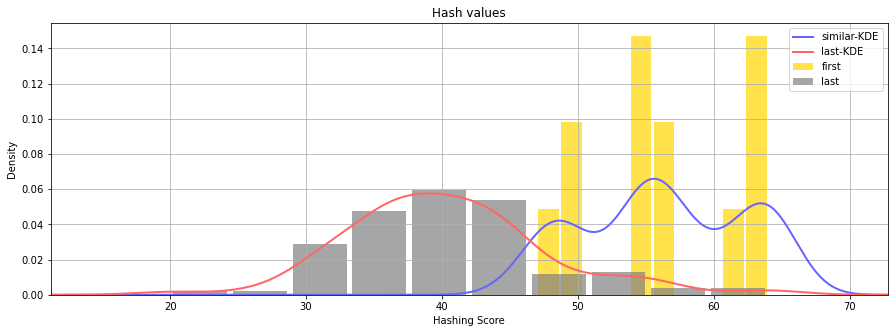

Mean value for groups: 56.33 +- 5.79
Mean value for non-groups: 40.32 +- 7.30

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 184 -- False positive: 6

Precision score: 0.9091
Recall score: 0.5000
F1 score: 0.6452


In [34]:
summary = {}

nonsimilar_hash = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='hash_value')
similar_hash = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='hash_value')

sc.plot_distributions(similar_hash, nonsimilar_hash, 
                      labels=('Hashing Score', 'Density'), title='Hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash.mean(), similar_hash.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash.mean(), nonsimilar_hash.std()))

summary.update({'hash_1':
        sc.performance_report(similar_hash, nonsimilar_hash, limit=56.33)})

## For Bhattacharyya correlation

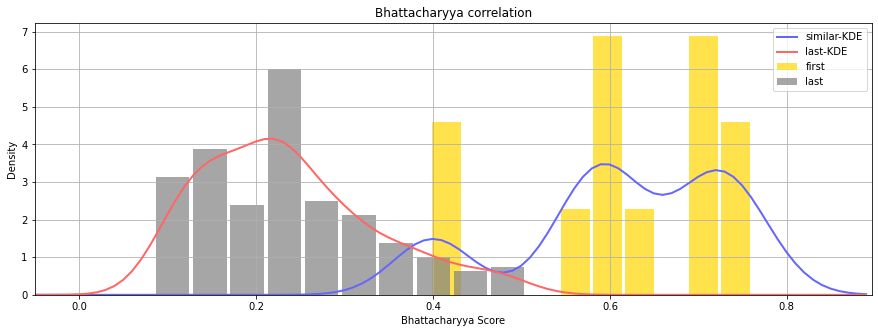

Mean value for groups: 0.61 +- 0.12
Mean value for non-groups: 0.24 +- 0.10

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.5000
F1 score: 0.6667


In [35]:
nonsimilar_bhatt = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='bhattacharyya_corr')
similar_bhatt = sc.return_dist(res, _type='similar', 
                                  target_col='target', comp_col='bhattacharyya_corr')

sc.plot_distributions(similar_bhatt, nonsimilar_bhatt, 
                   labels=('Bhattacharyya Score', 'Density'),
                   title='Bhattacharyya correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_bhatt.mean(), similar_bhatt.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_bhatt.mean(), nonsimilar_bhatt.std()))

summary.update({'bhattacharyya_1': 
            sc.performance_report(similar_bhatt, nonsimilar_bhatt, limit=0.61)})

## For plain correlation

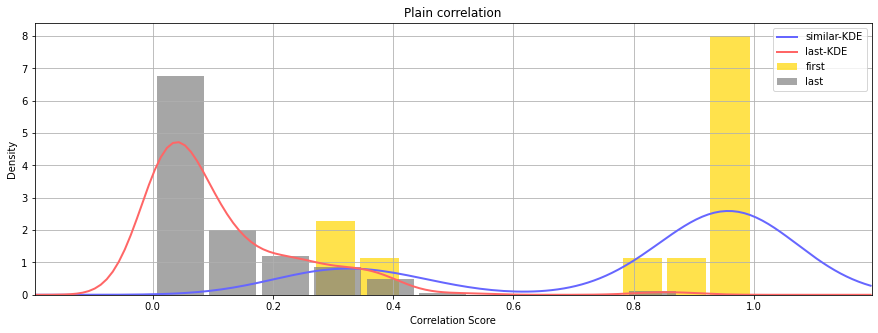

Mean value for groups: 0.80 +- 0.27
Mean value for non-groups: 0.12 +- 0.14

Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 188 -- False positive: 2

Precision score: 0.9783
Recall score: 0.7500
F1 score: 0.8491


In [36]:
nonsimilar_corr = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='correl_corr')
similar_corr = sc.return_dist(res, _type='similar', 
                                  target_col='target', comp_col='correl_corr')

sc.plot_distributions(similar_corr, nonsimilar_corr, 
                   labels=('Correlation Score', 'Density'),
                   title='Plain correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_corr.mean(), similar_corr.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_corr.mean(), nonsimilar_corr.std()))

summary.update({'correl_1': 
                sc.performance_report(similar_corr, nonsimilar_corr, limit=0.8)})

# Method 2: Logistic Regression fit

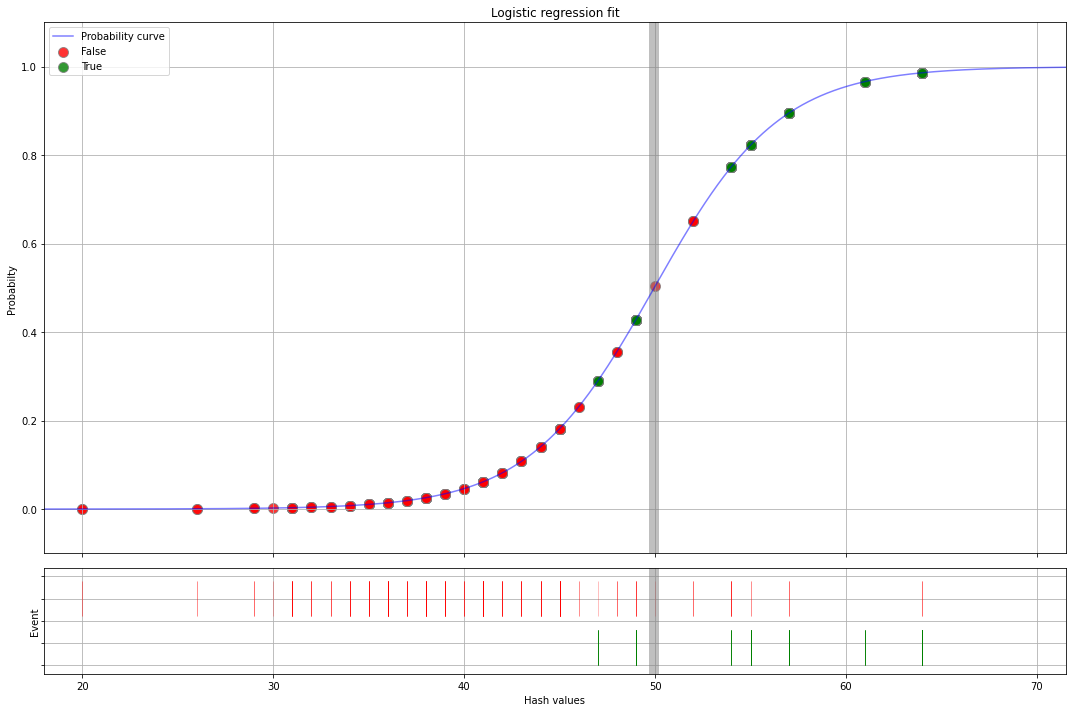

Limit at 49.95


49.95000000004149

In [37]:
sc.make_logreg_fit(similar_hash, nonsimilar_hash, 
                   labels=('Hash values', 'Probabilty'), limits=(20, 65))

In [38]:
summary.update({'hash_2':
            sc.performance_report(similar_hash, nonsimilar_hash, limit=49.95)})

Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 172 -- False positive: 18

Precision score: 0.8333
Recall score: 0.7500
F1 score: 0.7895


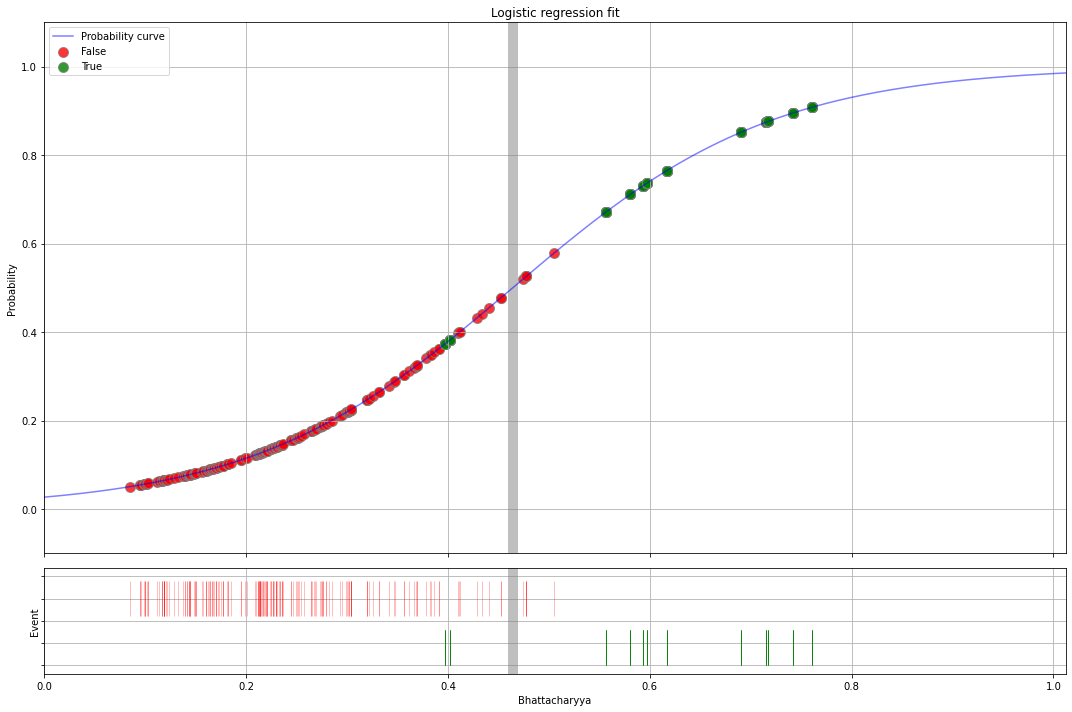

Limit at 0.46


0.464

In [39]:
sc.make_logreg_fit(similar_bhatt, nonsimilar_bhatt, 
                   labels=('Bhattacharyya', 'Probability'), limits=(0,0.92))

In [40]:
summary.update({'bhattacharyya_2':
        sc.performance_report(similar_bhatt, nonsimilar_bhatt, limit=0.46)})

Performance report
--------------------------------------------------
True positive: 100 -- False negative: 20
True negative: 184 -- False positive: 6

Precision score: 0.9434
Recall score: 0.8333
F1 score: 0.8850


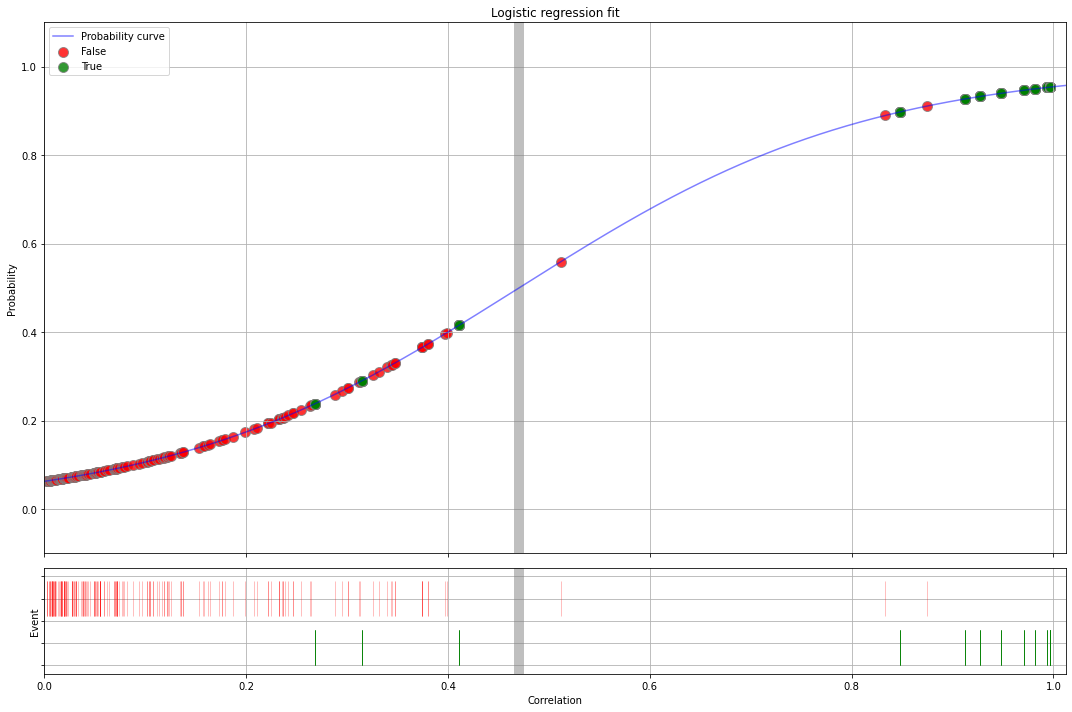

Limit at 0.47


0.47000000000000003

In [41]:
sc.make_logreg_fit(similar_corr, nonsimilar_corr, 
                labels=('Correlation', 'Probability'), limits=(0,0.92))

In [42]:
summary.update({'correl_2':
           sc.performance_report(similar_corr, nonsimilar_corr, limit=0.47)})

Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 187 -- False positive: 3

Precision score: 0.9677
Recall score: 0.7500
F1 score: 0.8451


# Evaluation of methods

In [49]:
summary = pd.DataFrame().from_dict(summary, orient='index',
                        columns=['precision', 'recall', 'f1'])
summary

,precision,recall,f1
hash_1,0.909091,0.500000,0.645161
bhattacharyya_1,1.000000,0.500000,0.666667
correl_1,0.978261,0.750000,0.849057
hash_2,0.833333,0.750000,0.789474
bhattacharyya_2,0.943396,0.833333,0.884956
correl_2,0.967742,0.750000,0.845070


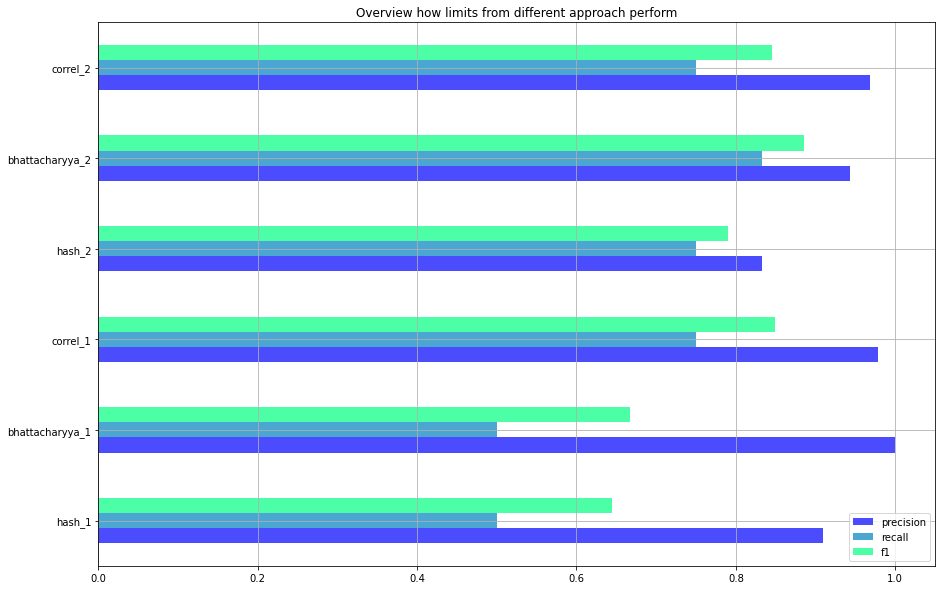

In [93]:
summary.plot.barh(alpha=0.7, figsize=(15, 10), grid=True, legend=True, 
                  title='Overview how limits from different approaches perform',
                  colormap='winter')

# taking the mean for the limits seems to make conservative distinctions
# the limits from logistic regression fits seem to yield better balanced
# results (f1-score)